In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import get_data
import statsmodels
from simulate import cholesky
from simulate import simulatedata
from simulate import simulate_multiple_time_series

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
syms = ['BTCUSDT']
freq = '10min'
start_date = '2020-01-01'
end_date = '2020-01-03'

In [11]:
raw_data = get_data.get_data(syms, freq, start_date, end_date)
raw_data

BTCUSDT_2019-12-26.json
BTCUSDT_2020-01-02.json


e:\trade\trade\get_data.py:52: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  data[symbol] = _fit_data_to_df(data[symbol], frequency)[start_time:end_time]


{'BTCUSDT':                               open     high      low    close      volume  \
 time                                                                        
 2020-01-01 00:00:00+00:00  7195.24  7196.25  7178.20  7191.07  154.874358   
 2020-01-01 00:10:00+00:00  7193.15  7193.53  7177.35  7178.29   80.261439   
 2020-01-01 00:20:00+00:00  7177.71  7185.56  7175.47  7178.45   96.049725   
 2020-01-01 00:30:00+00:00  7178.19  7185.44  7176.23  7177.53   59.973326   
 2020-01-01 00:40:00+00:00  7177.14  7182.99  7176.34  7182.94   44.872982   
 ...                            ...      ...      ...      ...         ...   
 2020-01-02 23:20:00+00:00  6959.16  6962.39  6950.00  6962.34  217.262815   
 2020-01-02 23:30:00+00:00  6962.47  6974.75  6957.66  6965.37  145.757951   
 2020-01-02 23:40:00+00:00  6965.09  6969.46  6959.87  6967.41   75.157310   
 2020-01-02 23:50:00+00:00  6967.40  6968.82  6961.24  6965.71   82.459841   
 2020-01-03 00:00:00+00:00  6965.49  6965.71  6948.45

In [12]:
dt = pd.DataFrame()
dt['close'] = raw_data['BTCUSDT']['close']
dt['high'] = raw_data['BTCUSDT']['high']
dt['low'] = raw_data['BTCUSDT']['low']
dt['open'] = raw_data['BTCUSDT']['open']
dt.iloc[150]

close    7202.09
high     7211.16
low      7201.58
open     7211.04
Name: 2020-01-02 01:00:00+00:00, dtype: float64

In [13]:
dt1 = pd.DataFrame()
dt1['close'] = dt['close'].pct_change()
dt1['open'] = dt['open'].pct_change()
dt1

,close,open
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-0.001777,-0.000290
2020-01-01 00:20:00+00:00,0.000022,-0.002146
2020-01-01 00:30:00+00:00,-0.000128,0.000067
2020-01-01 00:40:00+00:00,0.000754,-0.000146
...,...,...
2020-01-02 23:20:00+00:00,0.000457,-0.001664
2020-01-02 23:30:00+00:00,0.000435,0.000476
2020-01-02 23:40:00+00:00,0.000293,0.000376


In [15]:
var_close = simulate_multiple_time_series.compute_std(dt1['close'])
mean_close = dt1['close'].mean()
var_open = simulate_multiple_time_series.compute_std(dt1['open'])
mean_open = dt1['open'].mean()
chol = cholesky.cholesky2(dt1)
inverse_chol = np.linalg.inv(chol)
transform= simulate_multiple_time_series.transform_forward(dt1, inverse_chol)
transform

,close,open
time,,
2020-01-01 00:00:00+00:00,NaN,NaN
2020-01-01 00:10:00+00:00,-1.182001,-0.125515
2020-01-01 00:20:00+00:00,0.094338,-1.450368
2020-01-01 00:30:00+00:00,-0.012373,0.127281
2020-01-01 00:40:00+00:00,0.613140,-0.025640
...,...,...
2020-01-02 23:20:00+00:00,0.402634,-1.107060
2020-01-02 23:30:00+00:00,0.387205,0.417962
2020-01-02 23:40:00+00:00,0.286260,0.347333


In [17]:
order_close, seasonal_order_close = simulatedata.get_order(transform['close'][1:])
order_open, seasonal_order_open = simulatedata.get_order(transform['open'][1:])
order_close, seasonal_order_close, order_open, seasonal_order_open

((2, 0, 0), (0, 0, 0, 1), (2, 0, 0), (0, 0, 0, 1))

In [19]:
if sum(seasonal_order_close) == 1: seasonal_order_close = (0, 0, 0, 0)
model_params_close = simulatedata.fit_sarima(transform['close'][1:], order_close, seasonal_order_close)
if sum(seasonal_order_open) == 1: seasonal_order_open = (0, 0, 0, 0)
model_params_open = simulatedata.fit_sarima(transform['open'][1:], order_open, seasonal_order_open)

In [20]:
t_close = simulatedata.simulate_sarima(transform['close'][1:], order_close, seasonal_order_close, model_params_close, len(dt1), 1)
t_open = simulatedata.simulate_sarima(transform['open'][1:], order_open, seasonal_order_open, model_params_open, len(dt1), 1)

In [21]:
array = []
array = np.append(array, t_close)
array = np.append(array, t_open)
array = np.transpose(array.reshape(2,len(t_close[0])))
transform_x_chol = np.transpose(np.matmul(array, chol))

In [23]:
transform_x_chol = pd.DataFrame()
transform_x_chol['close'] = t_close[0]
transform_x_chol['open'] = t_open[0]
transform_back = simulate_multiple_time_series.transform_back(transform_x_chol, chol, var_close, mean_close, var_open, mean_open)
transform_back

,close,open
0,1.354957e-07,0.000049
1,1.354957e-07,0.000049
2,1.354957e-07,0.000049
3,1.354957e-07,0.000049
4,1.354957e-07,0.000049
...,...,...
284,1.354957e-07,0.000049
285,1.354957e-07,0.000049
286,1.354957e-07,0.000049
287,1.354957e-07,0.000049


In [24]:
simulated_price_data = pd.DataFrame()
simulated_price_data['close'] = simulatedata.construct_price_series(transform_back['close'], dt['close'][0], dt.index[0], freq)
simulated_price_data['open'] = simulatedata.construct_price_series(transform_back['open'], dt['open'][0], dt.index[0], freq)
simulated_price_data

,close,open
2020-01-01 00:00:00+00:00,7191.070000,7195.240000
2020-01-01 00:10:00+00:00,7191.070974,7195.589509
2020-01-01 00:20:00+00:00,7191.071949,7195.939034
2020-01-01 00:30:00+00:00,7191.072923,7196.288577
2020-01-01 00:40:00+00:00,7191.073897,7196.638137
...,...,...
2020-01-02 23:20:00+00:00,7191.346723,7295.185862
2020-01-02 23:30:00+00:00,7191.347698,7295.540226
2020-01-02 23:40:00+00:00,7191.348672,7295.894607
2020-01-02 23:50:00+00:00,7191.349647,7296.249005


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


KeyError: 0

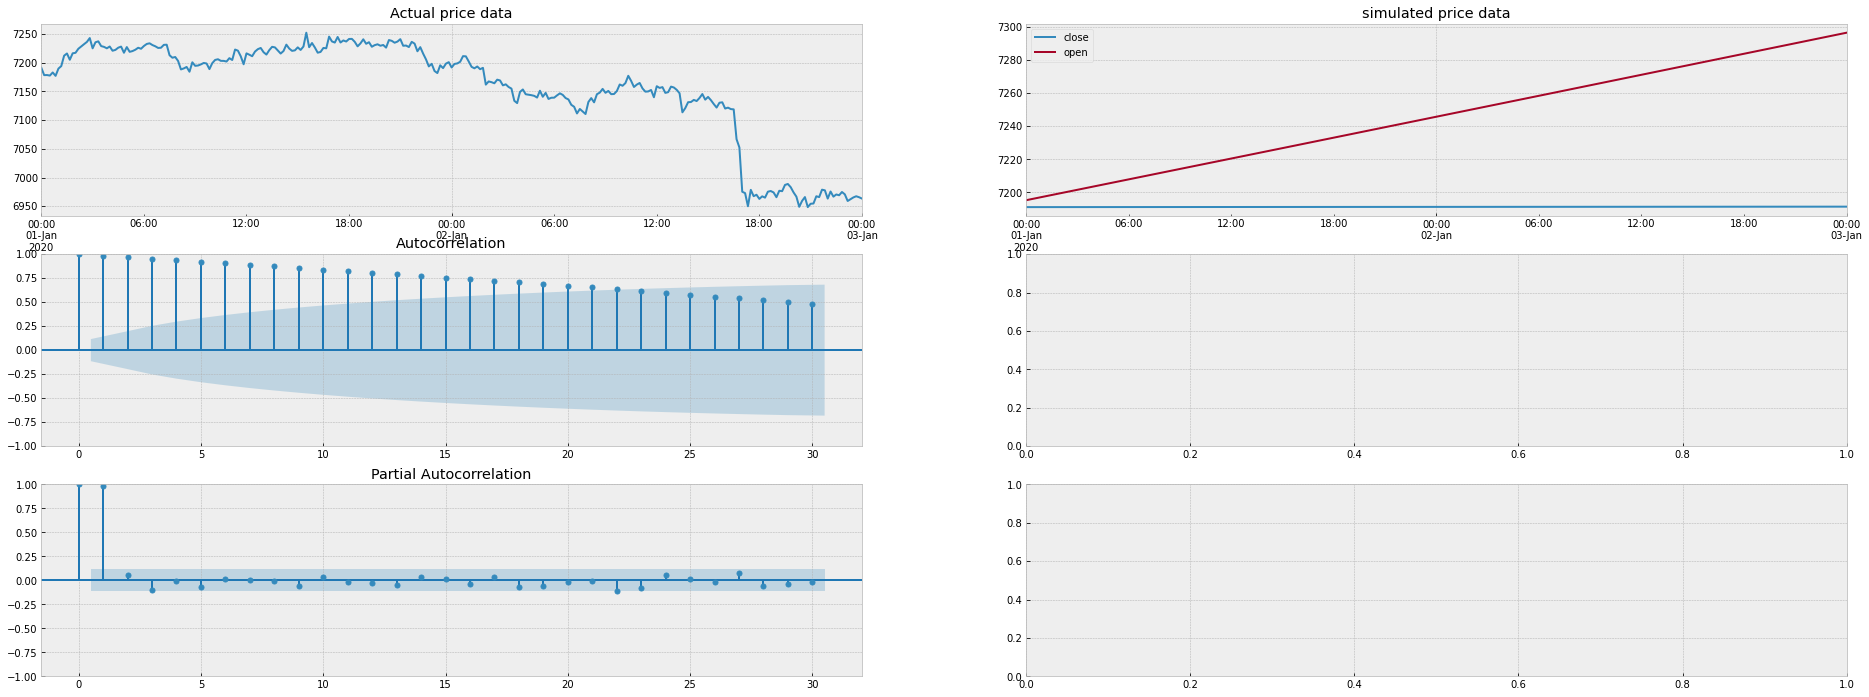

In [25]:
simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)

In [27]:
simulate_multiple_time_series.simulate_open_and_close(dt) # chạy từng lệnh ở trên thì ok mà chạy cả hàm lỗi là sao nhỉ 

KeyError: 'ret'

In [ ]:
order, seasonal_order = simulatedata.get_order(dt['open'][1:])
order, seasonal_order

In [ ]:
if sum(seasonal_order) == 1: seasonal_order = (0, 0, 0, 0)
model_params = simulatedata.fit_sarima(dt['open'][1:], order, seasonal_order)

In [ ]:
t = simulatedata.simulate_sarima(dt['open'][1:], order, seasonal_order, model_params, len(dt), 10)
t

In [ ]:
simulated_price_data = simulatedata.construct_price_series(t, dt['close'][0], dt.index[0], freq)

In [ ]:
simulatedata.Evaluate_performance(dt['close'], simulated_price_data, lags=30)